In [388]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

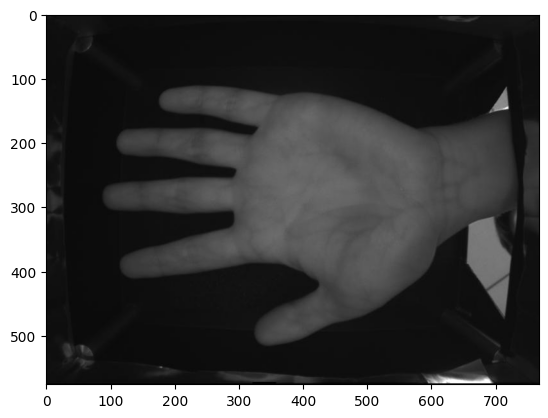

In [389]:
dataset = "/home/lucian/University/MSc-Courses/BiometricSystems/data/"
selected_person = "003"
selected_hand = "l"
selected_spectrum = "940"

pattern = f"{selected_person}_{selected_hand}_{selected_spectrum}_*.jpg"
matching_files = glob.glob(dataset + pattern)
selected_files = glob.glob(dataset + pattern)[:1]
plt.imshow(cv2.imread(selected_files[0]))

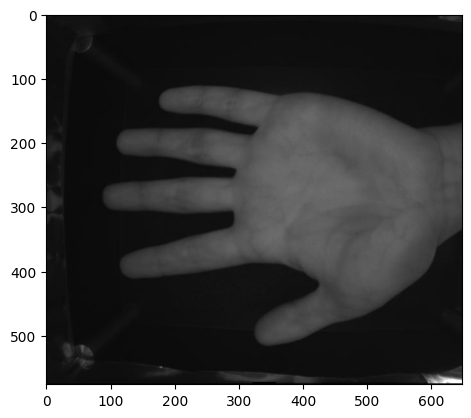

In [390]:
def load_and_crop_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[:, : image.shape[1] - 120]
    return cropped_image

cropped_image = load_and_crop_image(selected_files[0])

plt.imshow(cropped_image, cmap='gray')

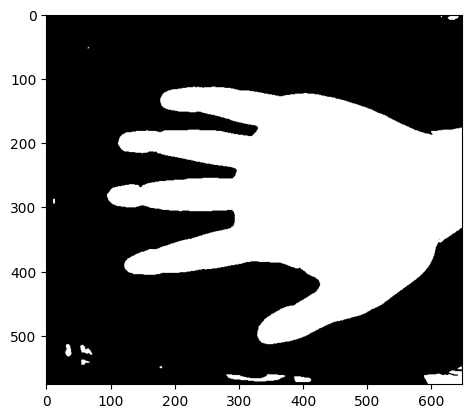

In [391]:
def preprocess_contours(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(
        thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

blurred = cv2.GaussianBlur(cropped_image, (5, 5), 0)
_, thresholded = cv2.threshold(blurred, 50, 255, cv2.THRESH_BINARY)
plt.imshow(thresholded, cmap='gray')

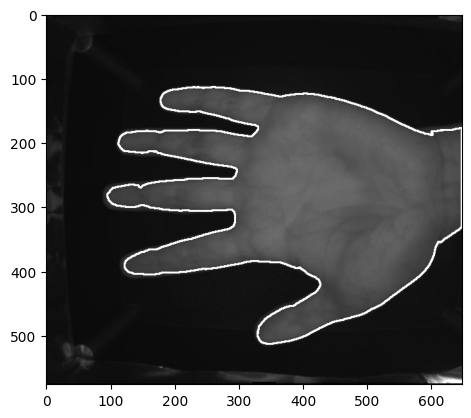

In [392]:
largest_contour = preprocess_contours(cropped_image)
contour_image = cv2.drawContours(cropped_image.copy(), [largest_contour], 0, 255, 2)
plt.imshow(contour_image, cmap='gray')

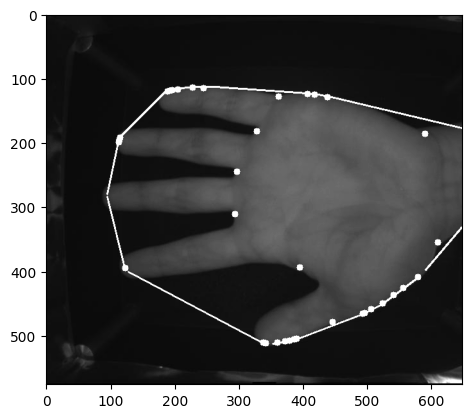

In [393]:
def find_defects(largest_contour):
    hull = cv2.convexHull(largest_contour, returnPoints=False)
    defects = cv2.convexityDefects(largest_contour, hull)
    return defects

def draw_defects(image, defects, largest_contour):
    for defect in defects:
        start, end, far, _ = defect[0]
        start = tuple(largest_contour[start][0])
        end = tuple(largest_contour[end][0])
        far = tuple(largest_contour[far][0])
        cv2.line(image, start, end, 255, 2)
        cv2.circle(image, far, 5, 255, -1)
    return image

defects = find_defects(largest_contour)
defect_image = draw_defects(cropped_image.copy(), defects, largest_contour)
plt.imshow(defect_image, cmap='gray')

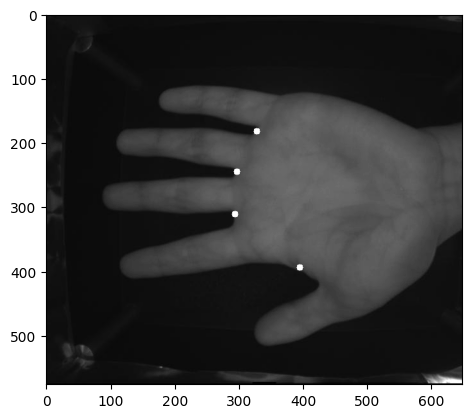

In [394]:
def get_far_points(defects, largest_contour):
    defects = sorted(defects, key=lambda x: x[0, 3], reverse=True)
    far_points = [tuple(largest_contour[defects[i][0][2]][0])for i in range(4)]
    return sorted(far_points, key=lambda point: point[1])

def draw_far_points(image, far_points):
    for point in far_points:
        cv2.circle(image, point, 5, 255, -1)
    return image

far_points = get_far_points(defects, largest_contour)
far_points_image = draw_far_points(cropped_image.copy(), far_points)
plt.imshow(far_points_image, cmap='gray')

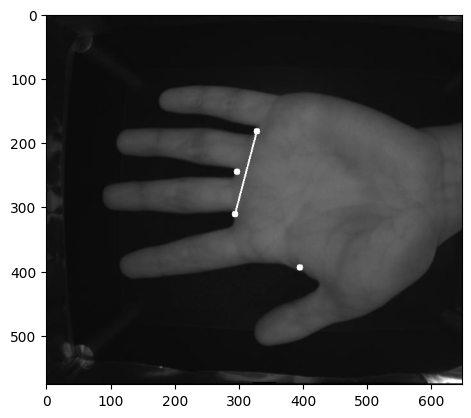

In [395]:
first_defect_far, third_defect_far = far_points[0], far_points[2]
cv2.line(far_points_image, first_defect_far, third_defect_far, 255, 2)
plt.imshow(far_points_image, cmap='gray')

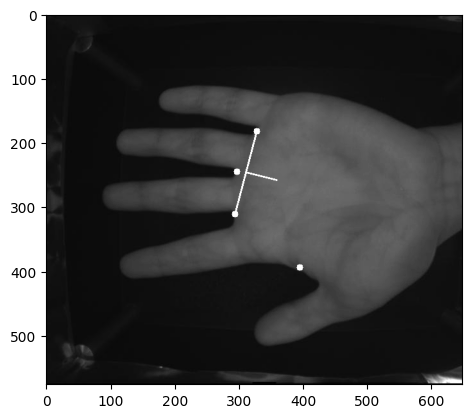

In [396]:
def compute_midpoint_and_direction(point1, point2):
    midpoint = (
        int((point1[0] + point2[0]) // 2),
        int((point1[1] + point2[1]) // 2),
    )
    dx = point2[0] - point1[0]
    dy = point2[1] - point1[1]
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length
    return midpoint, dx, dy, length

def compute_perpendicular_point(midpoint, dx, dy, distance=50):
    x_perpendicular = int(midpoint[0] + distance * dy)
    y_perpendicular = int(midpoint[1] - distance * dx)
    return x_perpendicular, y_perpendicular

midpoint, dx, dy, length = compute_midpoint_and_direction(first_defect_far, third_defect_far)
perpendicular_point = compute_perpendicular_point(midpoint, dx, dy)
cv2.line(far_points_image, midpoint,perpendicular_point, 255, 2)
plt.imshow(far_points_image, cmap='gray')

In [ ]:
def generate_square_vertices(perpendicular_point, length, offset=50):
    x, y = perpendicular_point
    vertices = [
        (x + offset, y),
        (x + offset, y - length),
        (x + offset + length, y - length),
        (x + offset + length, y),
    ]
    return vertices

def calculate_length(first_defect_far, third_defect_far):
    return int(np.sqrt((third_defect_far[0] - first_defect_far[0])**2 + (third_defect_far[1] - first_defect_far[1])**2))

def calculate_midpoint(midpoint):
    return (int(midpoint[0]), int(midpoint[1]))

def rotate_square(vertices, midpoint, angle):
    rotation_matrix = cv2.getRotationMatrix2D(midpoint, angle, scale=1)
    rotated_vertices = (
        cv2.transform(np.array([vertices], dtype=np.float32), rotation_matrix)
        .squeeze()
        .astype(np.int32)
    )
    return rotated_vertices

def translate_square(vertices, start_point):
    return vertices + start_point

def process_perpendicular_point(midpoint, perpendicular_point):
    x, y = perpendicular_point
    dx = x - midpoint[0]
    dy = y - midpoint[1]
    length = np.sqrt(dx**2 + dy**2)
    dx /= length
    dy /= length
    return dx, dy

length =  calculate_length(first_defect_far, third_defect_far)
square_vertices = generate_square_vertices(perpendicular_point, length)
angle = np.arctan2(-dy, dx) * 180 / np.pi
midpoint = calculate_midpoint(midpoint)
rotated_vertices = rotate_square(square_vertices, midpoint, angle)
start_point = (first_defect_far[0] - rotated_vertices[0][0],first_defect_far[1] - rotated_vertices[0][1])
translated_vertices = translate_square(rotated_vertices, start_point)
dx_perpendicular, dy_perpendicular = process_perpendicular_point(midpoint, perpendicular_point)

translation_vector = (int(50 * dx_perpendicular), int(50 * dy_perpendicular))

translated_along_perpendicular = translated_vertices + translation_vector
cv2.polylines(far_points_image, [translated_along_perpendicular], isClosed=True, color=[255, 0, 0], thickness=2)
plt.imshow(far_points_image, cmap='gray')

TypeError: process_perpendicular_point() takes 2 positional arguments but 3 were given

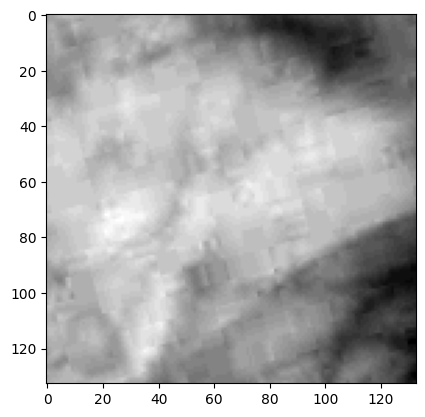

In [ ]:
def compute_transform(vertices, length):
    rectified_order = np.array(
        [[0, 0], [length, 0], [length, length], [0, length]], dtype=np.float32
    )
    return cv2.getPerspectiveTransform(vertices, rectified_order)
translated_along_perpendicular = np.array(translated_along_perpendicular, dtype=np.float32)
transform_matrix = compute_transform(translated_along_perpendicular, length)
rectified_image = cv2.warpPerspective(cropped_image, transform_matrix, (length, length))
plt.imshow(rectified_image, cmap='gray')

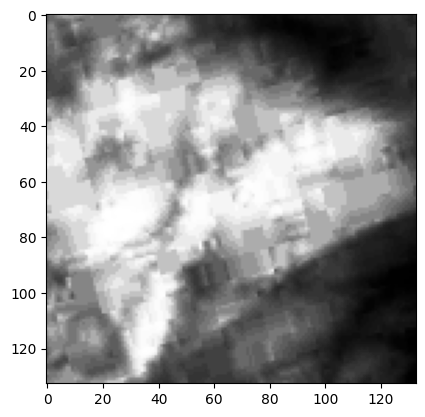

In [ ]:
rectified_image_equalized = cv2.equalizeHist(rectified_image)
plt.imshow(rectified_image_equalized, cmap='gray')